# Qiskit 8 - Perceptron

1. Introduction
2. Classical perceptron
3. Quantum perceptron

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, execute
from qiskit.tools.visualization import circuit_drawer, plot_histogram

## 1 - Classical perceptron

A classical perceptron can be said to act on a set of input signals by operating with an affine transformation of weights and biases on it and then applying some non-linear activation function on the sum to generate an output.

Let: 

$$x_n = input\,vector$$

$$W_{m\times n} = weight\,matrix$$

$$b_m = bias\,vector$$

$$\sigma_m = activation\,function$$

$$o_m = output\,vector$$

Then the affine part of the perceptron can be expressed as:

$$o_m = W_{m\times n}x_n + b_m$$

Activating that output gives:

$$a_m = \sigma_m(o_m) = \sigma_m(W_{m\times n}x_n + b_m)$$

Now for the sake of our experiment let $n = m = 4$, and let $x,\, W,$ and $b$ be initialized random uniform. Then we have the following.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


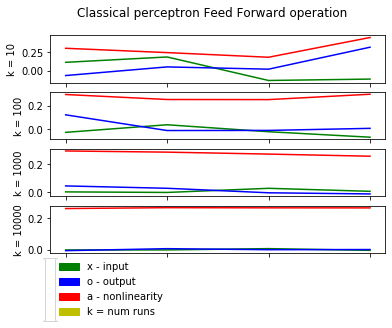

In [145]:
def classic_perceptron(K):
    '''Executes a perceptron for k runs and returns the result.'''
    n = m = 4
    result = list()
    for k in K:
        X, W_, B, O, A = list(), list(), list(), list(), list()
        for k_ in range(k):
            x = np.random.uniform(low=-1, high=1, size=n)
            W = np.random.uniform(low=-1, high=1, size=(m, n))
            b = np.random.uniform(low=-1, high=1, size=m)
            o = np.matmul(W, x)
            a = [0 if i < 0 else i for i in o]
            X.append(x)
            W_.append(W)
            B.append(b)
            O.append(o)
            A.append(a)
        result.append((X, W_, B, O, A, k))
    return result

result = classic_perceptron(K=(10, 100, 1000, 10000))
num_plots = len(result)
plt.subplot(num_plots, 1, 1)
plt.suptitle('Classical perceptron Feed Forward operation')
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)
    ax = np.arange(n)
    plt.plot(np.mean(result[i][0], axis=0), 'g')
    plt.plot(np.mean(result[i][3], axis=0), 'b')
    plt.plot(np.mean(result[i][4], axis=0), 'r')
    plt.xticks(ax, labels=[])
    plt.ylabel('k = ' + str(result[i][-1]))
red_patch = mpatches.Patch(color='g', label='x - input')
blue_patch = mpatches.Patch(color='b', label='o - output')
green_patch = mpatches.Patch(color='r', label='a - nonlinearity')
plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch], 
           bbox_to_anchor=(0, 0), mode='expand')
plt.show()

## 2 - Qauntum perceptron

Lets describe the classical implementation above in terms of its corresponding mapping such that:

$$x \mapsto \sigma(W * x + b)$$

Where $\sigma:\mathbb R \mapsto \mathbb R$ is a non-linear activation function.

In order to embed this mapping into a quantum circuit, first of all we need to make the whole process reversible since quantum computation has to be enacted by unitary and therefore invertible operations. If we assume the input, weights and activated output all to be quantum registers, on an abstract plane we can describe the mapping of a quantum perceptron to be as follows:

$$|x\rangle_I | w, b\rangle_W |0\rangle_A \mapsto |x\rangle_I | w, b\rangle_W | \sigma(w * x + b)\rangle_A$$

Which could be implemented by an idealized unitary:

$$e^{-i\sigma(w * x + b)}p_a$$

We will focus our first efforts though on storing the first part of the computation:

$$|x\rangle_I | w, b\rangle_W |0\rangle_C \mapsto |x\rangle_I | w, b\rangle_W |z\rangle_C$$

Where $c$ is a collector register in which the inputs and the weighted parts are accumulated where: $z = w * x + b$

The next part of the computation is to take the part collected in the $c$ collector register, and synthesis the computation of the activation function $\sigma : \mathbb R \mapsto \mathbb R$ as a quantum circuit: $|z\rangle_C|0\rangle_A \mapsto |z\rangle_C |\sigma(z)\rangle_A$, where $A$ labels a continuous quantum register.


#### Q1 - collector circuit

Now, let our first circuit represent the mapping: $|x\rangle_I | w, b\rangle_W |0\rangle_C \mapsto |x\rangle_I | w, b\rangle_W |z\rangle_C$

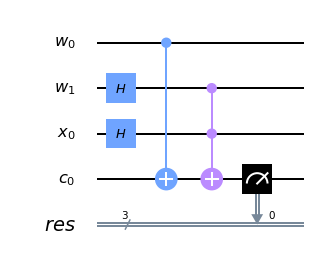

In [186]:
x = QuantumRegister(1, 'x')
w = QuantumRegister(1 + 1, 'w')
c = QuantumRegister(1, 'c')
res = ClassicalRegister(3, 'res')
Q1 = QuantumCircuit(w, x, c, res)
Q1.h(w[1])
Q1.h(x)
Q1.barrier()
Q1.cx(w[0], c) # bias
Q1.barrier()
Q1.ccx(x[0], w[1], c)
Q1.measure([c[0]], [res[0]])
circuit_drawer(Q1, output='mpl', plot_barriers=False)

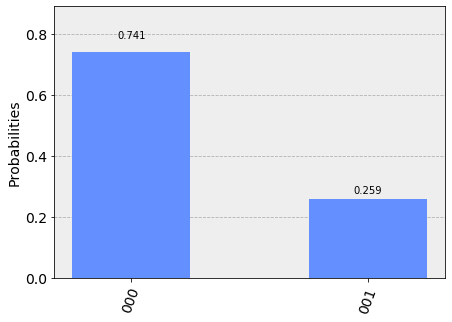

In [187]:
sim = Aer.get_backend('qasm_simulator')
count = execute(Q1, sim).result().get_counts()
plot_histogram(count)

#### To be continued...